# Using Stan Models: A Robust Linear Regression Example

We will approximate the posterior for the simple 2D robust linear regression model

$$\beta_i \sim \mathcal{N}(0, 10)$$
$$y_n | x_n, \beta, \sigma \sim \mathcal{T}_{40}(\beta^\top x_n, 1)$$

and use Stan to compute (the gradient of) the model log density. 

For more details and discussion of this example, see:

[Practical posterior error bounds from variational objectives](https://arxiv.org/abs/1910.04102).
Jonathan H. Huggins,
Miko&#0322;aj Kasprzak,
Trevor Campbell,
Tamara Broderick.
In *Proc. of the 23rd International Conference on Artificial Intelligence and
Statistics* (AISTATS), Palermo, Italy. PMLR: Volume 108, 2020.

In [1]:
import os
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
import pystan

from viabel import bbvi, vi_diagnostics, MultivariateT

In [2]:
# code for comparing to ground-truth posterior

sns.set_style('white')
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2})

def plot_approx_and_exact_contours(log_density, approx, var_param, cmap2='Reds'):
    xlim = [-4,-1]
    ylim = [-.5,3.5]
    xlist = np.linspace(*xlim, 100)
    ylist = np.linspace(*ylim, 100)
    X, Y = np.meshgrid(xlist, ylist)
    XY = np.concatenate([np.atleast_2d(X.ravel()), np.atleast_2d(Y.ravel())]).T
    zs = np.exp(log_density(XY))
    Z = zs.reshape(X.shape)
    zsapprox = np.exp(approx.log_density(var_param, XY))
    Zapprox = zsapprox.reshape(X.shape)
    cs_post = plt.contour(X, Y, Z, cmap='Greys', linestyles='solid')
    cs_post.collections[len(cs_post.collections)//2].set_label('Posterior')
    cs_approx = plt.contour(X, Y, Zapprox, cmap=cmap2, linestyles='solid')
    cs_approx.collections[len(cs_approx.collections)//2].set_label('Approximation')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend()
    plt.show()
    
def check_accuracy(true_mean, true_cov, var_param, approx):
    approx_mean, approx_cov = approx.mean_and_cov(var_param)
    true_std = np.sqrt(np.diag(true_cov))
    approx_std = np.sqrt(np.diag(approx_cov))
    mean_error=np.linalg.norm(true_mean - approx_mean)
    cov_error_2=np.linalg.norm(true_cov - approx_cov, ord=2)
    cov_norm_2=np.linalg.norm(true_cov, ord=2)
    std_error=np.linalg.norm(true_std - approx_std)
    
    print('mean error             = {:.3g}'.format(mean_error))
    print('stdev error            = {:.3g}'.format(std_error))
    print('||cov error||_2^{{1/2}}  = {:.3g}'.format(np.sqrt(cov_error_2)))
    print('||true cov||_2^{{1/2}}   = {:.3g}'.format(np.sqrt(cov_norm_2)))

First, compile the robust regression Stan model:

In [4]:
#compiled_model_file = 'robust_reg_model.pkl'
#try:
 #   with open(compiled_model_file, 'rb') as f:
  #      regression_model = pickle.load(f)
#except:
regression_model = pystan.StanModel(file='robust_regression.stan', 
                                        model_name='robust_regression')
#with open(compiled_model_file, 'wb') as f:
 #   pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL robust_regression_2f7d931ef1dc99d991576051801065c4 NOW.
In file included from /share/pkg.7/python3/3.7.7/install/lib/python3.7/site-packages/numpy-1.18.4-py3.7-linux-x86_64.egg/numpy/core/include/numpy/ndarraytypes.h:1832,
                 from /share/pkg.7/python3/3.7.7/install/lib/python3.7/site-packages/numpy-1.18.4-py3.7-linux-x86_64.egg/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /share/pkg.7/python3/3.7.7/install/lib/python3.7/site-packages/numpy-1.18.4-py3.7-linux-x86_64.egg/numpy/core/include/numpy/arrayobject.h:4,
                 from /scratch/1231765.1.b/pystan_9k_3mri1/stanfit4robust_regression_2f7d931ef1dc99d991576051801065c4_4242142388673878667.cpp:685:
/share/pkg.7/python3/3.7.7/install/lib/python3.7/site-packages/numpy-1.18.4-py3.7-linux-x86_64.egg/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1

Next, to as use a data, generate 25 observations from the model with $\beta = (-2, 1)$:

In [5]:
np.random.seed(5039)
beta_gen = np.array([-2, 1])
N = 25
x = np.random.randn(N, 2).dot(np.array([[1,.75],[.75, 1]]))
y_raw = x.dot(beta_gen) + np.random.standard_t(40, N)
y = y_raw - np.mean(y_raw)

For illustration purposes, generate ground-truth posterior samples using Stan's dynamic HMC implementation:

In [6]:
data = dict(N=N, x=x, y=y, df=40)
fit = regression_model.sampling(data=data, iter=50000, thin=50, chains=4)
true_mean = np.mean(fit['beta'], axis=0)
true_cov = np.cov(fit['beta'].T)


Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 50000 [  0%]  (Warmup)

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 50000 [  0%]  (Warmup)

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 50000 [  0%]  (Warmup)

Gradient evaluation took 0 seconds
1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 50000 [  0%]  (Warmup)
Iteration:  5000 / 50000 [ 10%]  (Warmup)
Iteration:  5000 / 50000 [ 10%]  (Warmup)
Iteration:  5000 / 50000 [ 10%]  (Warmup)
Iteration:  5000 / 50000 [ 10%]  (Warmup)
Iteration: 10000 / 50000 [ 20%]  (Warmup)
Iterat

## Standard mean-field variational inference

As a first example, we compute a mean field variational approximation using standard variational inference -- that is, by maximimizing the evidence lower bound (ELBO):

In [7]:
mf_results = bbvi(2, n_iters=5000, fit=fit, num_mc_samples=50, learning_rate=.1)

Average Loss = 21.353: 100%|██████████| 5000/5000 [00:20<00:00, 242.73it/s]


We can check approximation quality using `vi_diagnostics`, which determines the approximation is not good:

In [8]:
mf_objective = mf_results['objective']
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    diagnostics = vi_diagnostics(mf_results['var_param'], objective=mf_objective, 
                                 n_samples=100000)

Pareto k is estimated to be khat = 0.95


Indeed, due to the strong posterior correlation, the variational approximation dramatically underestimates uncertainty:

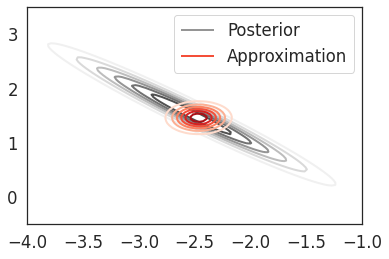

In [9]:
plot_approx_and_exact_contours(mf_objective.model, mf_objective.approx, 
                               mf_results['var_param'])

We can confirm the poor approximation quality numerically by examining the mean, standard deviation, and covariance errors as compared to the ground-truth estimates:

In [10]:
check_accuracy(true_mean, true_cov, mf_results['var_param'], mf_objective.approx)

mean error             = 0.0712
stdev error            = 0.689
||cov error||_2^{1/2}  = 0.887
||true cov||_2^{1/2}   = 0.9


## An approximation with full covariance

To get a good approximation, we can instead use a Multivariate *t* variational family with a full-rank scaling matrix:

In [11]:
t_results = bbvi(2, n_iters=2500, fit=fit, approx=MultivariateT(2, 100), 
                 num_mc_samples=100, learning_rate=.1)

Average Loss = 22.712: 100%|██████████| 2500/2500 [00:20<00:00, 122.48it/s]


The diagnostics suggest the approximation is accurate:

In [12]:
t_objective = t_results['objective']
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    diagnostics = vi_diagnostics(t_results['var_param'], objective=t_objective, 
                                 n_samples=100000)

Pareto k is estimated to be khat = -0.90

The 2-divergence is estimated to be d2 = 0.051

All diagnostics pass.


Visual inspection and numerical checks confirm the diagnostics:

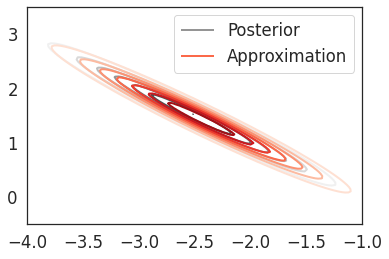

In [13]:
plot_approx_and_exact_contours(t_objective.model, t_objective.approx, t_results['var_param'])

In [14]:
check_accuracy(true_mean, true_cov, t_results['var_param'], t_objective.approx)

mean error             = 0.104
stdev error            = 0.0451
||cov error||_2^{1/2}  = 0.286
||true cov||_2^{1/2}   = 0.9
